In [45]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from sklearn.feature_selection import VarianceThreshold
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns

print('Importing data...')
path = 'Data/'
data = pd.read_csv(path+'application_train.csv')
test = pd.read_csv(path+'application_test.csv')
prev = pd.read_csv(path+'previous_application.csv')
buro = pd.read_csv(path+'bureau.csv')
buro_balance = pd.read_csv(path+'bureau_balance.csv')
credit_card  = pd.read_csv(path+'credit_card_balance.csv')
POS_CASH  = pd.read_csv(path+'POS_CASH_balance.csv')
payments = pd.read_csv(path+'installments_payments.csv')
lgbm_submission = pd.read_csv(path+'sample_submission.csv')

#Separate target variable
y = data['TARGET']
del data['TARGET']

Importing data...


In [46]:
#One-hot encoding of categorical features in data and test sets
categorical_features = [col for col in data.columns if data[col].dtype == 'object']

one_hot_df = pd.concat([data,test])
one_hot_df = pd.get_dummies(one_hot_df, columns=categorical_features)

data = one_hot_df.iloc[:data.shape[0],:]
test = one_hot_df.iloc[data.shape[0]:,]

In [47]:
#Pre-processing previous_application
print('Pre-processing previous_application...')
#One-hot encoding of categorical features in previous application data set
prev_cat_features = [pcol for pcol in prev.columns if prev[pcol].dtype == 'object']
prev = pd.get_dummies(prev, columns=prev_cat_features)
avg_prev = prev.groupby('SK_ID_CURR').mean()
cnt_prev = prev[['SK_ID_CURR', 'SK_ID_PREV']].groupby('SK_ID_CURR').count()
avg_prev['nb_app'] = cnt_prev['SK_ID_PREV']
del avg_prev['SK_ID_PREV']

Pre-processing previous_application...


In [48]:
#Pre-processing buro_balance
print('Pre-processing buro_balance...')
buro_grouped_size = buro_balance.groupby('SK_ID_BUREAU')['MONTHS_BALANCE'].size()
buro_grouped_max = buro_balance.groupby('SK_ID_BUREAU')['MONTHS_BALANCE'].max()
buro_grouped_min = buro_balance.groupby('SK_ID_BUREAU')['MONTHS_BALANCE'].min()
buro_grouped_median = buro_balance.groupby('SK_ID_BUREAU')['MONTHS_BALANCE'].median()

buro_counts = buro_balance.groupby('SK_ID_BUREAU')['STATUS'].value_counts(normalize = False)
buro_counts_unstacked = buro_counts.unstack('STATUS')
buro_counts_unstacked.columns = ['STATUS_0', 'STATUS_1','STATUS_2','STATUS_3','STATUS_4','STATUS_5','STATUS_C','STATUS_X',]
buro_counts_unstacked['MONTHS_COUNT'] = buro_grouped_size
buro_counts_unstacked['MONTHS_MIN'] = buro_grouped_min
buro_counts_unstacked['MONTHS_MAX'] = buro_grouped_max
buro_counts_unstacked['MONTHS_MEDIAN'] = buro_grouped_median
buro = buro.join(buro_counts_unstacked, how='left', on='SK_ID_BUREAU')

Pre-processing buro_balance...


In [49]:
#Pre-processing buro
print('Pre-processing buro...')

buro_active = buro.groupby('SK_ID_CURR')['CREDIT_ACTIVE'].value_counts(normalize = False)
buro_active_unstacked = buro_active.unstack('CREDIT_ACTIVE')
buro_active_unstacked.columns = ['CREDIT_ACTIVE_A','CREDIT_ACTIVE_B','CREDIT_ACTIVE_C','CREDIT_ACTIVE_S']

buro_credittype = buro.groupby('SK_ID_CURR')['CREDIT_TYPE'].value_counts(normalize = False)
buro_credittype_unstacked = buro_credittype.unstack('CREDIT_TYPE')
buro_credittype_unstacked.columns = 'CREDIT_TYPE_' + buro_credittype_unstacked.columns

del buro['CREDIT_ACTIVE']
del buro['CREDIT_TYPE']

#One-hot encoding of categorical features in buro data set
buro_cat_features = [bcol for bcol in buro.columns if buro[bcol].dtype == 'object']
buro = pd.get_dummies(buro, columns=buro_cat_features)

avg_buro = buro.groupby('SK_ID_CURR').mean()
avg_buro['buro_count'] = buro[['SK_ID_BUREAU', 'SK_ID_CURR']].groupby('SK_ID_CURR').count()['SK_ID_BUREAU']
del avg_buro['SK_ID_BUREAU']

max_buro = buro.groupby('SK_ID_CURR').max()
max_buro.columns = max_buro.columns + '_max'
max_buro.rename(columns={'SK_ID_CURR_max': 'SK_ID_CURR'}, inplace=True)
del max_buro['SK_ID_BUREAU_max']
min_buro = buro.groupby('SK_ID_CURR').min()
min_buro.columns = min_buro.columns + '_min'
min_buro.rename(columns={'SK_ID_CURR_min': 'SK_ID_CURR'}, inplace=True)
del min_buro['SK_ID_BUREAU_min']

Pre-processing buro...


In [50]:
#Pre-processing POS_CASH
print('Pre-processing POS_CASH...')
le = LabelEncoder()
POS_CASH['NAME_CONTRACT_STATUS'] = le.fit_transform(POS_CASH['NAME_CONTRACT_STATUS'].astype(str))
nunique_status = POS_CASH[['SK_ID_CURR', 'NAME_CONTRACT_STATUS']].groupby('SK_ID_CURR').nunique()
nunique_status2 = POS_CASH[['SK_ID_CURR', 'NAME_CONTRACT_STATUS']].groupby('SK_ID_CURR').max()
POS_CASH['NUNIQUE_STATUS'] = nunique_status['NAME_CONTRACT_STATUS']
POS_CASH['NUNIQUE_STATUS2'] = nunique_status2['NAME_CONTRACT_STATUS']
POS_CASH.drop(['SK_ID_PREV', 'NAME_CONTRACT_STATUS'], axis=1, inplace=True)

Pre-processing POS_CASH...


In [51]:
#Pre-processing credit_card
print('Pre-processing credit_card...')
credit_card['NAME_CONTRACT_STATUS'] = le.fit_transform(credit_card['NAME_CONTRACT_STATUS'].astype(str))
nunique_status = credit_card[['SK_ID_CURR', 'NAME_CONTRACT_STATUS']].groupby('SK_ID_CURR').nunique()
nunique_status2 = credit_card[['SK_ID_CURR', 'NAME_CONTRACT_STATUS']].groupby('SK_ID_CURR').max()
credit_card['NUNIQUE_STATUS'] = nunique_status['NAME_CONTRACT_STATUS']
credit_card['NUNIQUE_STATUS2'] = nunique_status2['NAME_CONTRACT_STATUS']
credit_card.drop(['SK_ID_PREV', 'NAME_CONTRACT_STATUS'], axis=1, inplace=True)

Pre-processing credit_card...


In [52]:
#Pre-processing payments
print('Pre-processing payments...')
avg_payments = payments.groupby('SK_ID_CURR').mean()
avg_payments2 = payments.groupby('SK_ID_CURR').max()
avg_payments3 = payments.groupby('SK_ID_CURR').min()
del avg_payments['SK_ID_PREV']

Pre-processing payments...


In [53]:
#Join data bases
print('Joining databases...')
data = data.merge(right=avg_prev.reset_index(), how='left', on='SK_ID_CURR')
test = test.merge(right=avg_prev.reset_index(), how='left', on='SK_ID_CURR')

data = data.merge(right=max_buro.reset_index(), how='left', on='SK_ID_CURR')
test = test.merge(right=max_buro.reset_index(), how='left', on='SK_ID_CURR')

data = data.merge(right=avg_buro.reset_index(), how='left', on='SK_ID_CURR')
test = test.merge(right=avg_buro.reset_index(), how='left', on='SK_ID_CURR')

data = data.merge(right=min_buro.reset_index(), how='left', on='SK_ID_CURR')
test = test.merge(right=min_buro.reset_index(), how='left', on='SK_ID_CURR')

data = data.merge(right=buro_active_unstacked.reset_index(), how='left', on='SK_ID_CURR')
test = test.merge(right=buro_active_unstacked.reset_index(), how='left', on='SK_ID_CURR')

data = data.merge(right=buro_credittype_unstacked.reset_index(), how='left', on='SK_ID_CURR')
test = test.merge(right=buro_credittype_unstacked.reset_index(), how='left', on='SK_ID_CURR')

data = data.merge(POS_CASH.groupby('SK_ID_CURR').mean().reset_index(), how='left', on='SK_ID_CURR')
test = test.merge(POS_CASH.groupby('SK_ID_CURR').mean().reset_index(), how='left', on='SK_ID_CURR')

data = data.merge(credit_card.groupby('SK_ID_CURR').mean().reset_index(), how='left', on='SK_ID_CURR')
test = test.merge(credit_card.groupby('SK_ID_CURR').mean().reset_index(), how='left', on='SK_ID_CURR')

data = data.merge(right=avg_payments.reset_index(), how='left', on='SK_ID_CURR')
test = test.merge(right=avg_payments.reset_index(), how='left', on='SK_ID_CURR')

data = data.merge(right=avg_payments2.reset_index(), how='left', on='SK_ID_CURR')
test = test.merge(right=avg_payments2.reset_index(), how='left', on='SK_ID_CURR')

data = data.merge(right=avg_payments3.reset_index(), how='left', on='SK_ID_CURR')
test = test.merge(right=avg_payments3.reset_index(), how='left', on='SK_ID_CURR')

Joining databases...


In [54]:
data.columns

Index(['SK_ID_CURR', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT_x',
       'AMT_ANNUITY_x', 'AMT_GOODS_PRICE_x', 'REGION_POPULATION_RELATIVE',
       'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION',
       ...
       'DAYS_ENTRY_PAYMENT_y', 'AMT_INSTALMENT_y', 'AMT_PAYMENT_y',
       'SK_ID_PREV_y', 'NUM_INSTALMENT_VERSION', 'NUM_INSTALMENT_NUMBER',
       'DAYS_INSTALMENT', 'DAYS_ENTRY_PAYMENT', 'AMT_INSTALMENT',
       'AMT_PAYMENT'],
      dtype='object', length=561)

In [55]:
data['X1'] = data['AMT_CREDIT_x']/data['AMT_INCOME_TOTAL']
data['X2'] = data['AMT_CREDIT_y']/data['AMT_INCOME_TOTAL']
data['X3'] = data['AMT_ANNUITY']/data['AMT_INCOME_TOTAL']
data['X4'] = data['AMT_ANNUITY_x']/data['AMT_INCOME_TOTAL']
data['X5'] = data['AMT_ANNUITY_y']/data['AMT_INCOME_TOTAL']
data['X6'] = data['AMT_CREDIT_x']/data['AMT_ANNUITY_x']
data['X7'] = data['AMT_CREDIT_y']/data['AMT_ANNUITY_x']
data['X8'] = data['AMT_CREDIT_x']/data['AMT_ANNUITY_y']
data['X9'] = data['AMT_CREDIT_y']/data['AMT_ANNUITY_y']
data['X10'] = data['AMT_CREDIT_SUM']/data['AMT_CREDIT_x']
data['x11'] = data['AMT_CREDIT_SUM']/data['AMT_CREDIT_y']
data['X12'] = data['AMT_CREDIT_SUM_DEBT']/data['AMT_CREDIT_x']
data['X13'] = data['AMT_CREDIT_SUM_DEBT']/data['AMT_CREDIT_y']
data['X14'] = data['AMT_CREDIT_SUM_DEBT']/data['AMT_INCOME_TOTAL']
data['X15'] = data['AMT_ANNUITY_x']/data['AMT_CREDIT_y']
data['X16'] = data['AMT_ANNUITY_y']/data['AMT_CREDIT_x']
data['X17'] = data['AMT_ANNUITY_x']/data['AMT_CREDIT_x']
data['X18'] = data['AMT_ANNUITY_y']/data['AMT_CREDIT_y']


test['X1'] = test['AMT_CREDIT_x']/test['AMT_INCOME_TOTAL']
test['X2'] = test['AMT_CREDIT_y']/test['AMT_INCOME_TOTAL']
test['X3'] = test['AMT_ANNUITY']/test['AMT_INCOME_TOTAL']
test['X4'] = test['AMT_ANNUITY_x']/test['AMT_INCOME_TOTAL']
test['X5'] = test['AMT_ANNUITY_y']/test['AMT_INCOME_TOTAL']
test['X6'] = test['AMT_CREDIT_x']/test['AMT_ANNUITY_x']
test['X7'] = test['AMT_CREDIT_y']/test['AMT_ANNUITY_x']
test['X8'] = test['AMT_CREDIT_x']/test['AMT_ANNUITY_y']
test['X9'] = test['AMT_CREDIT_y']/test['AMT_ANNUITY_y']
test['X10'] = test['AMT_CREDIT_SUM']/test['AMT_CREDIT_x']
test['x11'] = test['AMT_CREDIT_SUM']/test['AMT_CREDIT_y']
test['X12'] = test['AMT_CREDIT_SUM_DEBT']/test['AMT_CREDIT_x']
test['X13'] = test['AMT_CREDIT_SUM_DEBT']/test['AMT_CREDIT_y']
test['X14'] = test['AMT_CREDIT_SUM_DEBT']/test['AMT_INCOME_TOTAL']
test['X15'] = test['AMT_ANNUITY_x']/test['AMT_CREDIT_y']
test['X16'] = test['AMT_ANNUITY_y']/test['AMT_CREDIT_x']
test['X17'] = test['AMT_ANNUITY_x']/test['AMT_CREDIT_x']
test['X18'] = test['AMT_ANNUITY_y']/test['AMT_CREDIT_y']

In [56]:
#Remove features with many missing values
print('Removing features with more than 80% missing...')
test = test[test.columns[data.isnull().mean() < 0.8]]
data = data[data.columns[data.isnull().mean() < 0.8]]

Removing features with more than 80% missing...


In [57]:
#Delete customer Id
del data['SK_ID_CURR']
del test['SK_ID_CURR']

In [58]:
#Create train and validation set
train_x, valid_x, train_y, valid_y = train_test_split(data, y, test_size=0.2, shuffle=True)

In [59]:
#------------------------Build LightGBM Model-----------------------
train_data=lgb.Dataset(train_x,label=train_y)
valid_data=lgb.Dataset(valid_x,label=valid_y)

#Select Hyper-Parameters
params = {'boosting_type': 'gbdt',
          'max_depth' : 10,
          'objective': 'binary',
          'nthread': 5,
          'num_leaves': 64,
          'learning_rate': 0.05,
          'max_bin': 512,
          'subsample_for_bin': 200,
          'subsample': 1,
          'subsample_freq': 1,
          'colsample_bytree': 0.8,
          'reg_alpha': 5,
          'reg_lambda': 10,
          'min_split_gain': 0.5,
          'min_child_weight': 1,
          'min_child_samples': 5,
          'scale_pos_weight': 1,
          'num_class' : 1,
          'metric' : 'auc'
          }


In [60]:
#Train model on selected parameters and number of iterations
lgbm = lgb.train(params,
                 train_data,
                 2500,
                 valid_sets=valid_data,
                 early_stopping_rounds= 40,
                 verbose_eval= 10
                 )

Training until validation scores don't improve for 40 rounds.
[10]	valid_0's auc: 0.730463
[20]	valid_0's auc: 0.735149
[30]	valid_0's auc: 0.7414
[40]	valid_0's auc: 0.748614
[50]	valid_0's auc: 0.754389
[60]	valid_0's auc: 0.759389
[70]	valid_0's auc: 0.763705
[80]	valid_0's auc: 0.768276
[90]	valid_0's auc: 0.772053
[100]	valid_0's auc: 0.775268
[110]	valid_0's auc: 0.777926
[120]	valid_0's auc: 0.780059
[130]	valid_0's auc: 0.781689
[140]	valid_0's auc: 0.783138
[150]	valid_0's auc: 0.784253
[160]	valid_0's auc: 0.785439
[170]	valid_0's auc: 0.786198
[180]	valid_0's auc: 0.787021
[190]	valid_0's auc: 0.787569
[200]	valid_0's auc: 0.788117
[210]	valid_0's auc: 0.788543
[220]	valid_0's auc: 0.789079
[230]	valid_0's auc: 0.789491
[240]	valid_0's auc: 0.789883
[250]	valid_0's auc: 0.790239
[260]	valid_0's auc: 0.790634
[270]	valid_0's auc: 0.790771
[280]	valid_0's auc: 0.790979
[290]	valid_0's auc: 0.791124
[300]	valid_0's auc: 0.791426
[310]	valid_0's auc: 0.791449
[320]	valid_0's auc

In [61]:
#Predict on test set and write to submit
predictions_lgbm_prob = lgbm.predict(test)

lgbm_submission.TARGET = predictions_lgbm_prob

lgbm_submission.to_csv('lgbm_submission.csv', index=False)

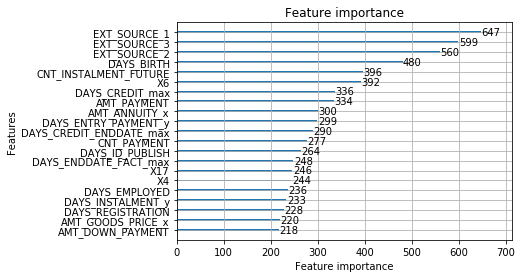

In [62]:
#Plot Variable Importances
lgb.plot_importance(lgbm, max_num_features=21, importance_type='split')